The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
# training_subfolder = "wind_near_wall_wo_bemt_in_control_train_xz_wind"
training_subfolder = "wind_near_wall_wo_bemt_in_control_far_from_wall"  # training in no wall condition
# training_subfolder = "nf_training_back2back"
# validation_subfolder = "nf_validation_back2back"
validation_subfolder = "wind_near_wall_validation_no_bemt"
# validation_subfolder = "wind_near_wall_validation_no_bemt_sinusoidal"

def generate_data_list(subfolder):
    """
    Generate a list of data files in the specified subfolder.
    """
    folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Filter out files that do not end with .csv
    file_names = [f for f in file_names if f.endswith('.csv')]
    # add subfolder to the file names
    data_list = [os.path.join(subfolder, f) for f in file_names]
    return data_list

data_list = generate_data_list(training_subfolder)
print("Training Data List:")
for data in data_list:
    print(data)

validation_list = generate_data_list(validation_subfolder)
print("\nValidation Data List:")
for data in validation_list:
    print(data)

path1 = os.path.join(training_subfolder, "input_label_map_disturbance_force_label.yaml")

Training Data List:
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_z3_0_d100_4_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_zn3_0_d100_4_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_xn1_0_y0_0_z0_0_d100_4_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_xn1_0_y0_0_z3_0_d100_4_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_xn1_0_y0_0_z5_0_d100_4_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_xn1_0_y0_0_zn3_0_d100_4_train_no_bemt.csv
w

- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Setting up data factory...
Loading normalization params file from
..\data\training\wind_near_wall_wo_bemt_in_control_far_from_wall\normalization_params.yaml
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_train_no_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_z3_0_d100_4_train_no_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_train_no_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_zn3_0_d100_4_train_no_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0

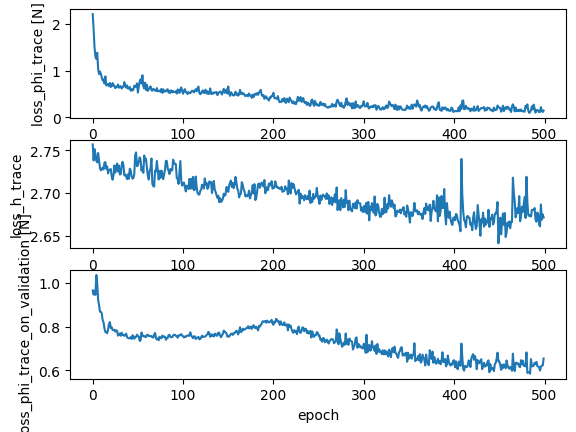

In [2]:
# use the data from previous section to train the model

factory = training_manager.PipelineFactory(training_manager.ModelArchitecture.DIAML)
manager = factory.make_training_pipeline()
manager.set_up(
    training_data_menu=data_list,
    # training_data_menu=data_list[:4],    # use small data list for quick testing
    validation_data_menu=validation_list[-1:],
    input_label_map_file=path1,
    can_inspect_data=False
)
plt.show() 
manager.train()

plt.show()  

Inspect data in the data list.

Plotting t-SNE of a_trace...


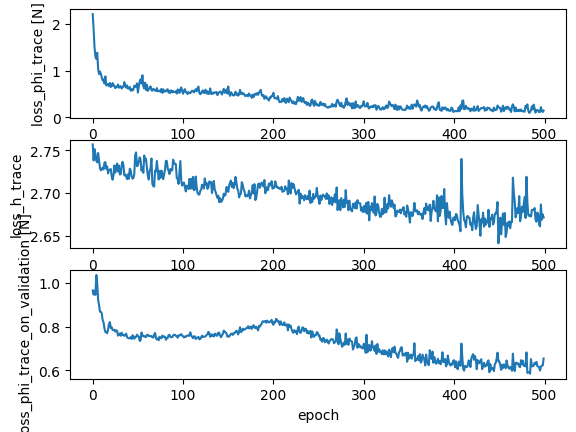

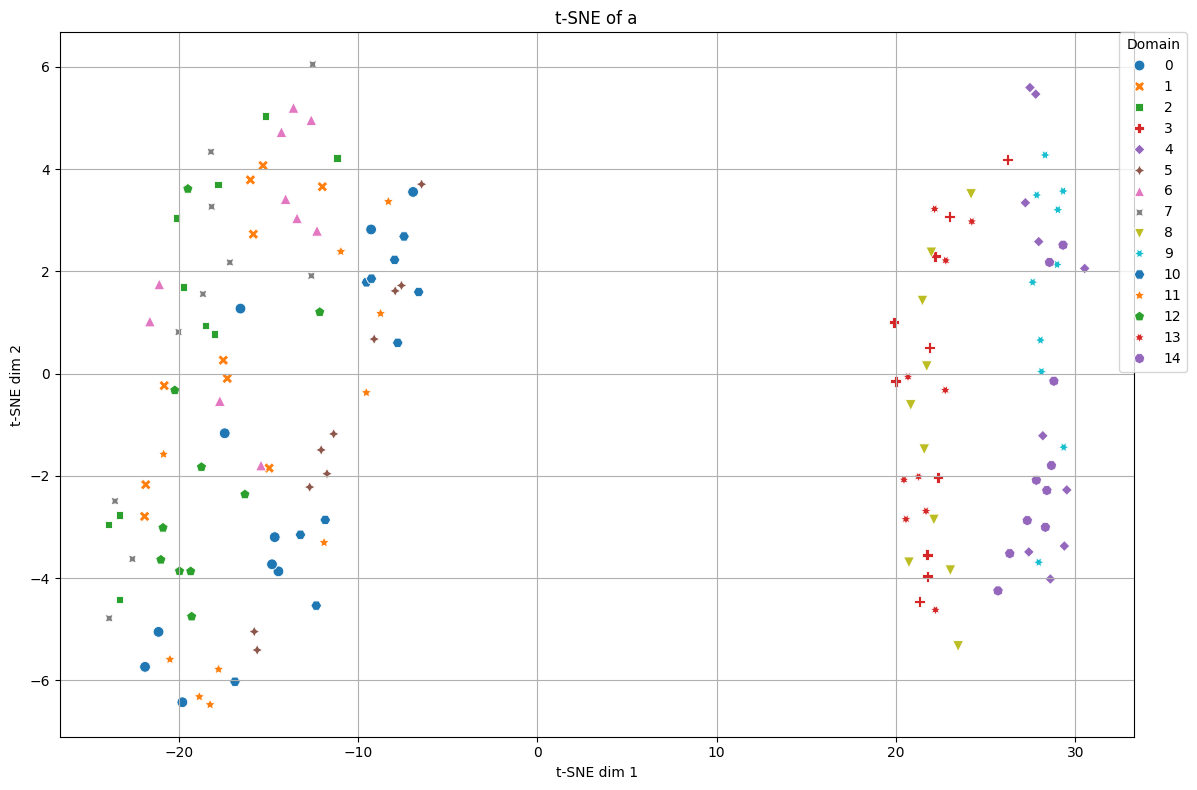

In [3]:
# trainer_instance.inspect_data(data_list[:2])
manager.show_result_only()

After training, we can save the model in the following way.

In [4]:
model_name = training_subfolder
manager.save_model(model_name)

Model saved to model\wind_near_wall_wo_bemt_in_control_far_from_wall.pth


Test the model using the test set.

test Data List:
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wi

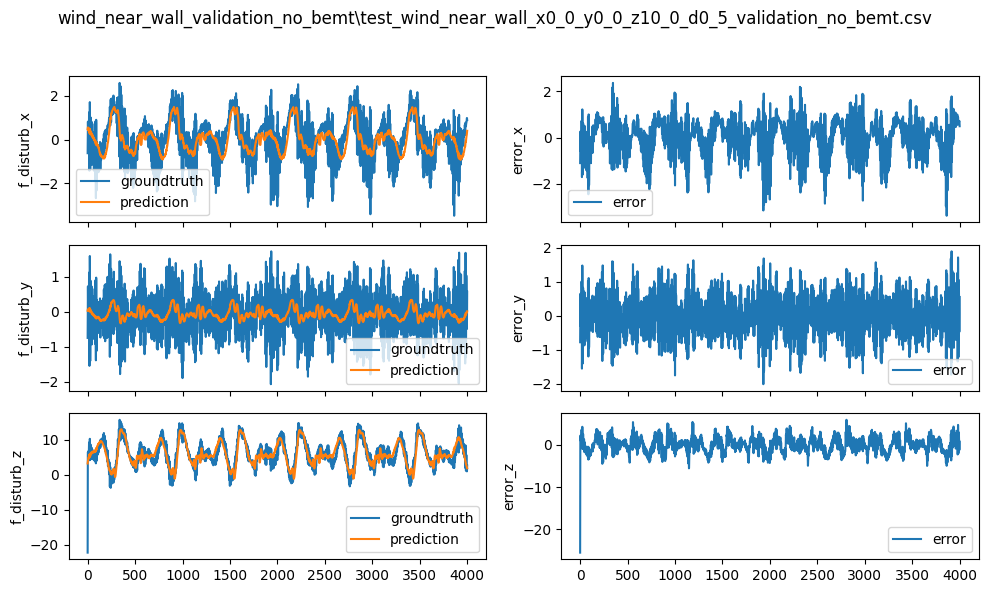

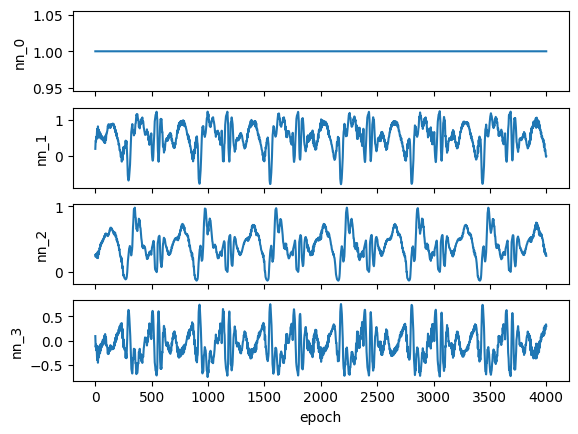

phi_out: tensor([[ 1.0000,  0.1980,  0.2612,  0.0915],
        [ 1.0000,  0.2578,  0.2408,  0.0304],
        [ 1.0000,  0.3632,  0.2142, -0.0778],
        ...,
        [ 1.0000, -0.1185,  0.0766,  0.2364],
        [ 1.0000, -0.0973,  0.0651,  0.2100],
        [ 1.0000, -0.0646,  0.0486,  0.1756]])
a = tensor([[  0.7206,   0.3930,   0.2199],
        [ -1.1453,  -0.2789,  -7.8594],
        [ -1.2051,  -1.3853,   8.9712],
        [ -2.9760,  -1.7419, -15.2762]])


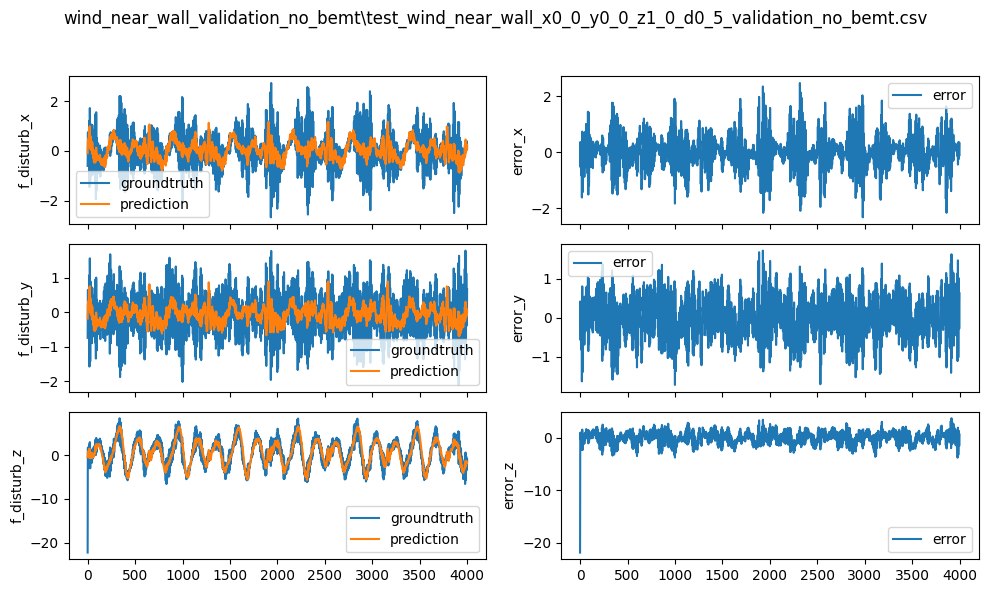

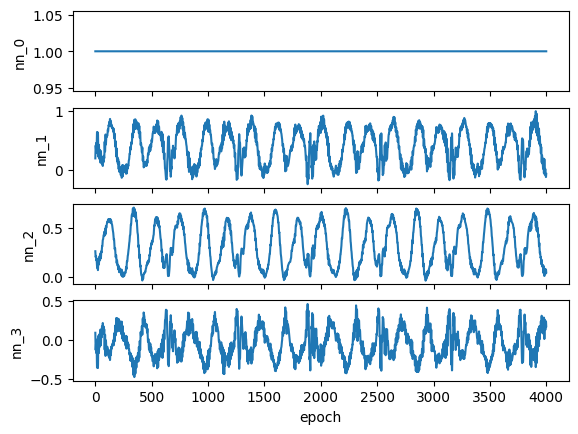

phi_out: tensor([[ 1.0000,  0.1961,  0.2624,  0.0933],
        [ 1.0000,  0.2566,  0.2446,  0.0327],
        [ 1.0000,  0.3672,  0.2196, -0.0797],
        ...,
        [ 1.0000, -0.1251,  0.0851,  0.2605],
        [ 1.0000, -0.1021,  0.0720,  0.2312],
        [ 1.0000, -0.0648,  0.0519,  0.1881]])
a = tensor([[  0.7117,   0.3550,   1.6828],
        [ -1.5745,  -0.6486,  -9.5916],
        [ -0.2621,  -0.5673,  12.6238],
        [ -2.2860,  -1.2503, -15.8518]])


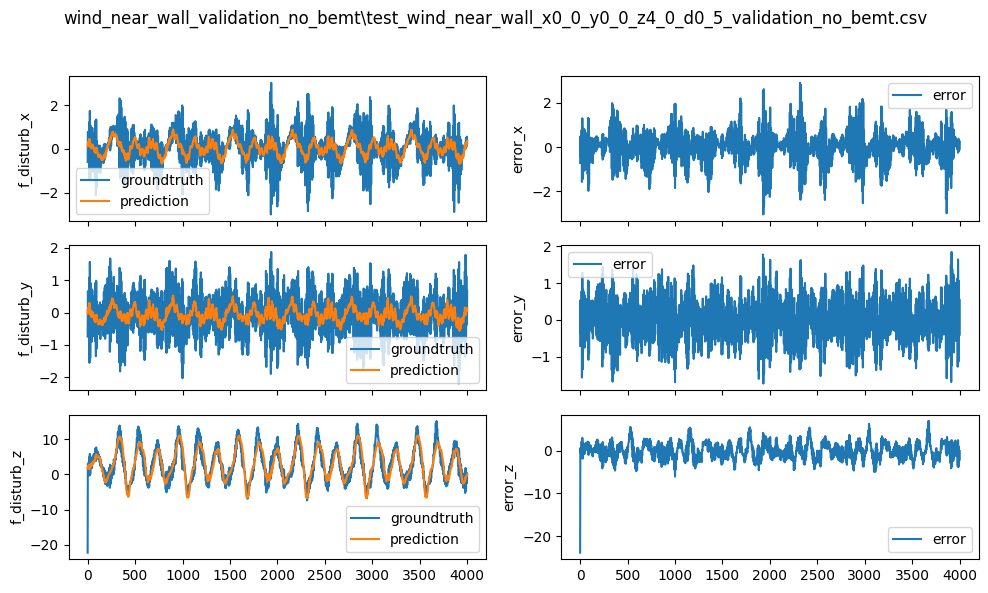

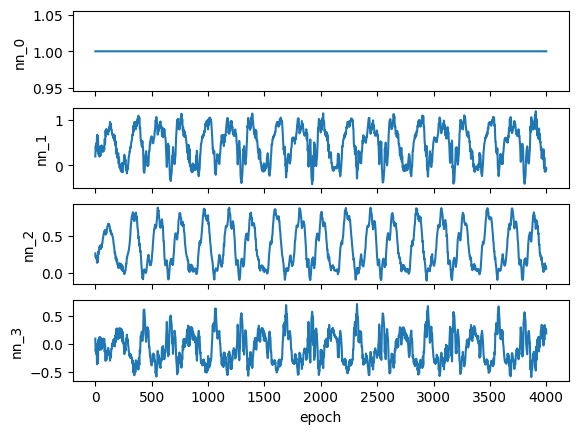

phi_out: tensor([[ 1.0000,  0.1980,  0.2635,  0.0902],
        [ 1.0000,  0.2690,  0.2524,  0.0228],
        [ 1.0000,  0.3818,  0.2369, -0.0876],
        ...,
        [ 1.0000, -0.0253,  0.1275,  0.2405],
        [ 1.0000,  0.0073,  0.1126,  0.1973],
        [ 1.0000,  0.0872,  0.0839,  0.1048]])
a = tensor([[ 0.5322,  0.3153,  3.5741],
        [-0.9646,  0.4697,  1.9167],
        [-0.7303, -1.8768,  0.1067],
        [-2.8417, -1.2831, -3.1256]])


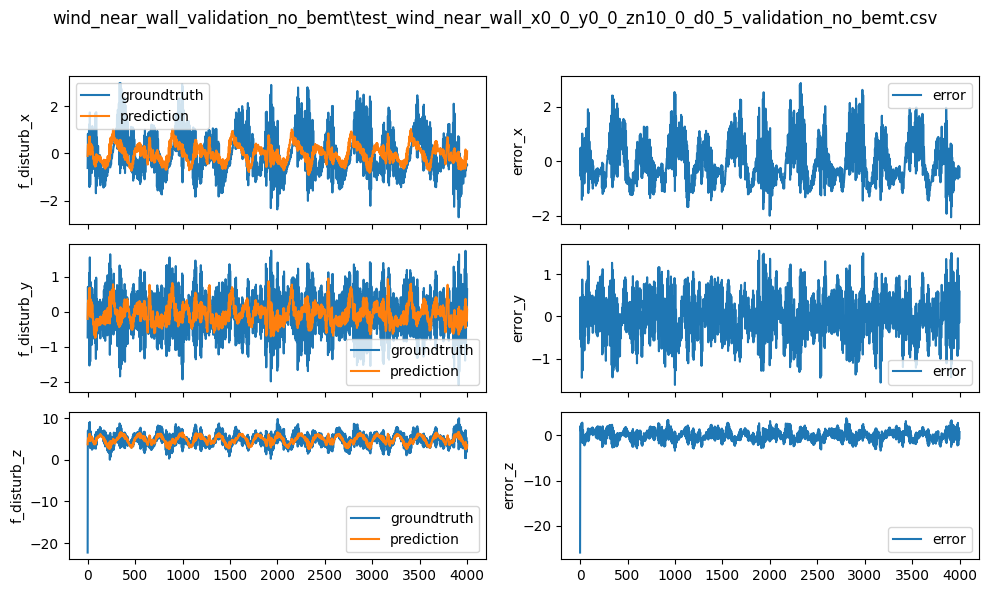

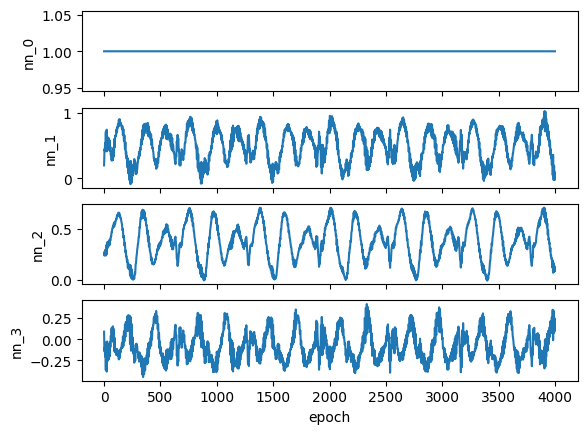

phi_out: tensor([[ 1.0000,  0.1988,  0.2605,  0.0911],
        [ 1.0000,  0.2540,  0.2382,  0.0334],
        [ 1.0000,  0.3583,  0.2085, -0.0748],
        ...,
        [ 1.0000, -0.0851,  0.0805,  0.2104],
        [ 1.0000, -0.0655,  0.0690,  0.1845],
        [ 1.0000, -0.0275,  0.0499,  0.1392]])
a = tensor([[  0.7006,   0.3939,  -0.2347],
        [ -1.1276,  -0.2485,  -7.4984],
        [ -1.2895,  -1.4942,   7.6031],
        [ -3.0001,  -1.7447, -13.9544]])


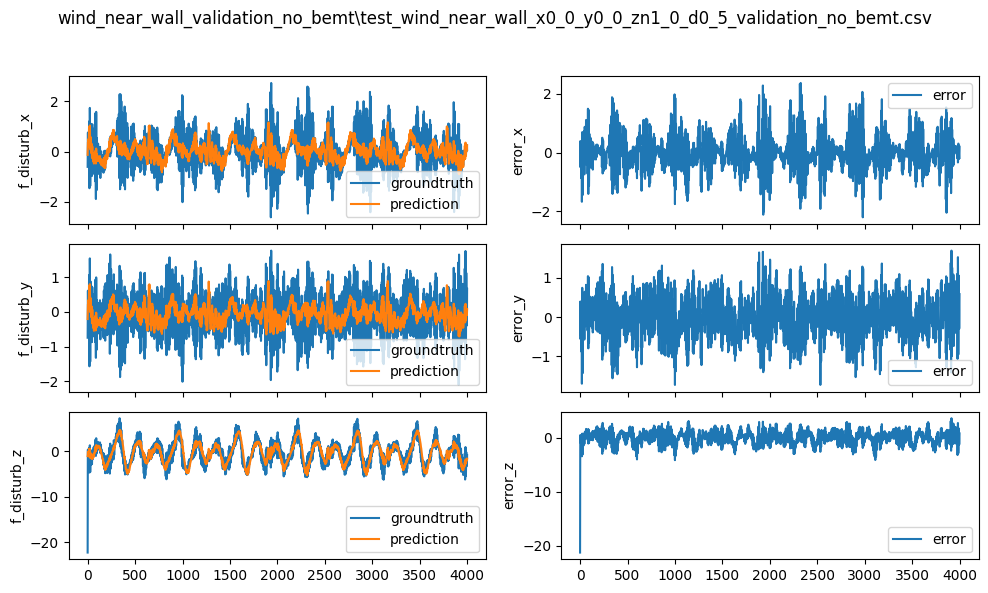

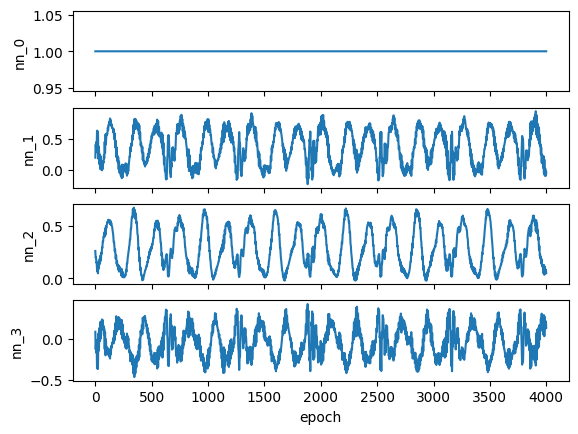

phi_out: tensor([[ 1.0000e+00,  1.9607e-01,  2.6177e-01,  9.3657e-02],
        [ 1.0000e+00,  2.5894e-01,  2.3860e-01,  2.8865e-02],
        [ 1.0000e+00,  3.6408e-01,  2.1042e-01, -7.9511e-02],
        ...,
        [ 1.0000e+00, -6.6184e-02,  9.3325e-02,  2.0430e-01],
        [ 1.0000e+00, -4.9167e-02,  8.2863e-02,  1.8086e-01],
        [ 1.0000e+00, -6.6318e-04,  6.0980e-02,  1.2424e-01]])
a = tensor([[ 0.6959,  0.3594, -0.0336],
        [-0.9993,  0.0814, -2.9372],
        [-1.5094, -1.7912,  2.6714],
        [-3.0993, -1.5830, -8.5009]])


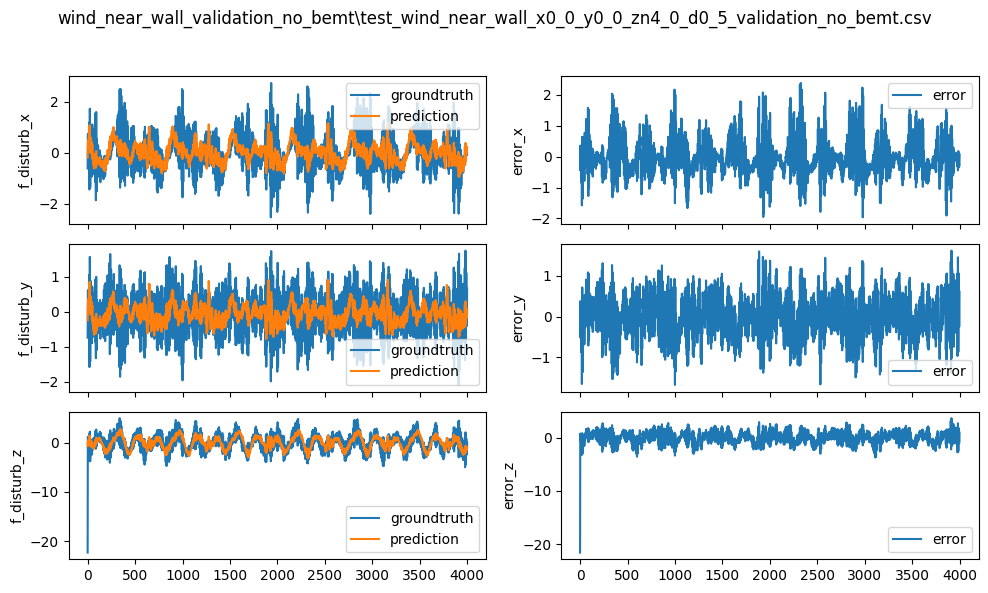

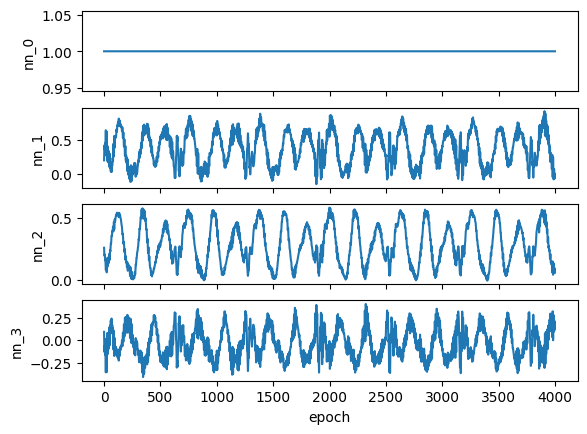

phi_out: tensor([[ 1.0000,  0.1960,  0.2637,  0.0924],
        [ 1.0000,  0.2794,  0.2423,  0.0114],
        [ 1.0000,  0.4035,  0.2173, -0.1114],
        ...,
        [ 1.0000,  0.0725,  0.2633,  0.2693],
        [ 1.0000,  0.0720,  0.2416,  0.2578],
        [ 1.0000,  0.0832,  0.2175,  0.2344]])
a = tensor([[ 0.8285,  0.2510,  0.5641],
        [-2.8020, -0.4202,  0.7044],
        [ 0.0833, -0.3469, 11.6334],
        [-3.3583, -0.5417, -5.0113]])


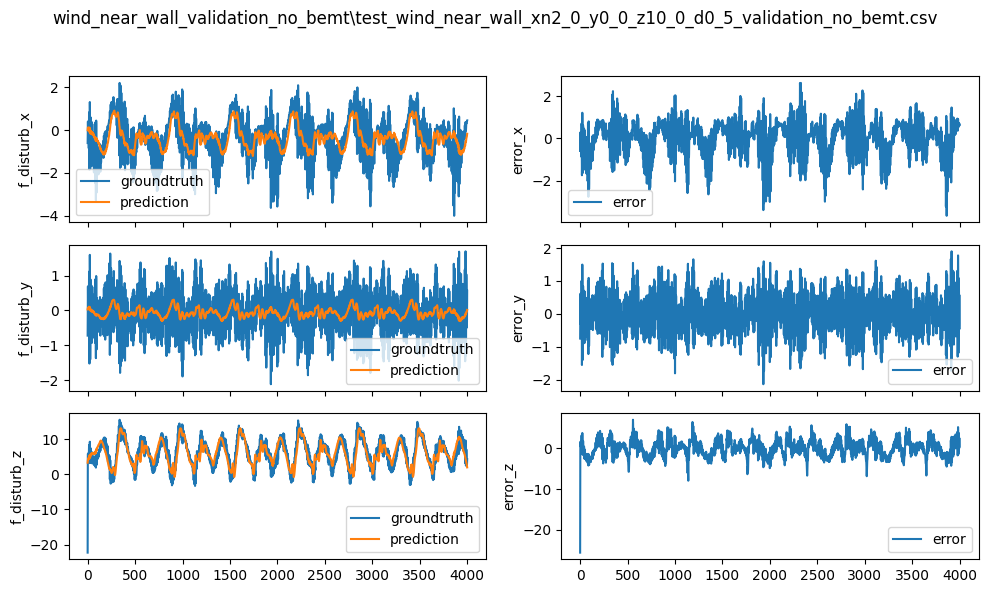

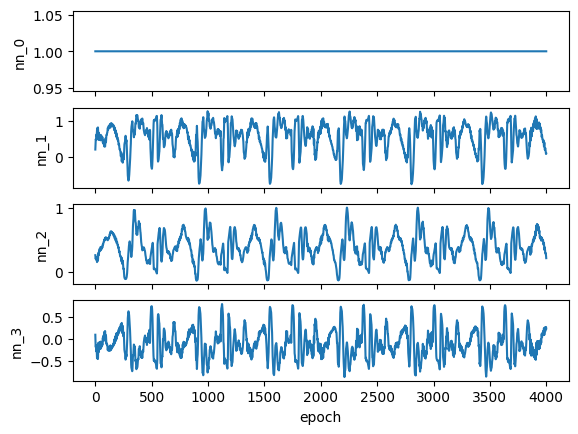

phi_out: tensor([[ 1.0000,  0.1967,  0.2618,  0.0927],
        [ 1.0000,  0.2687,  0.2355,  0.0193],
        [ 1.0000,  0.3795,  0.2055, -0.0938],
        ...,
        [ 1.0000, -0.0693,  0.0623,  0.2010],
        [ 1.0000, -0.0449,  0.0486,  0.1699],
        [ 1.0000, -0.0139,  0.0336,  0.1327]])
a = tensor([[  0.5381,   0.3638,   0.1433],
        [ -1.1146,  -0.2462,  -7.2203],
        [ -1.5490,  -1.3882,   9.0009],
        [ -3.0565,  -1.7047, -14.0754]])


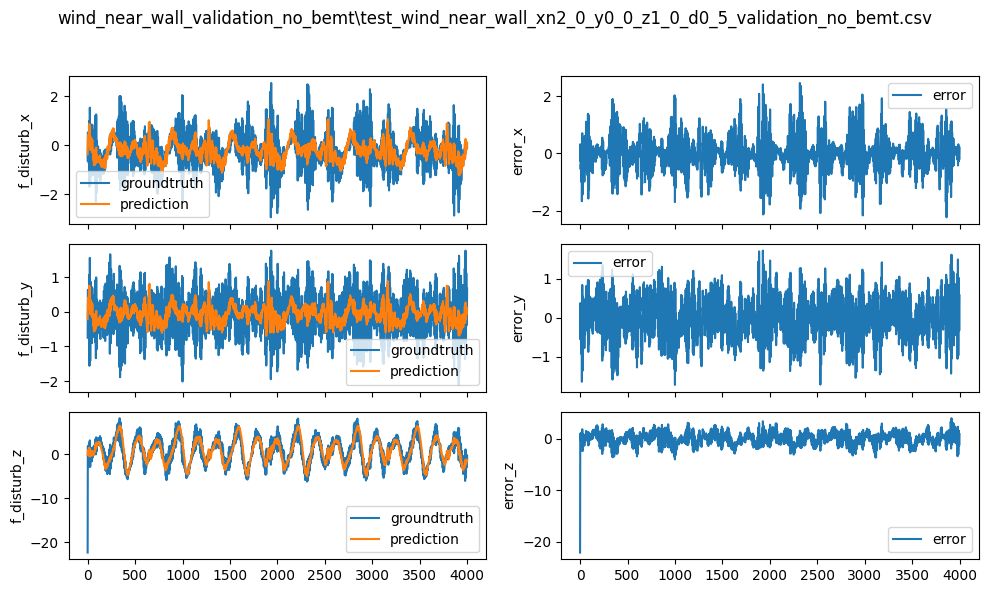

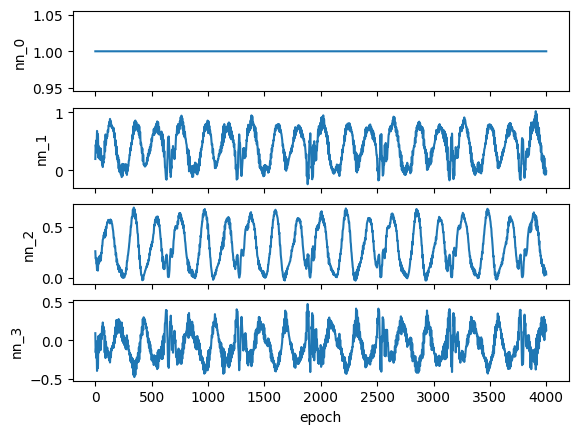

phi_out: tensor([[ 1.0000,  0.1962,  0.2629,  0.0927],
        [ 1.0000,  0.2685,  0.2423,  0.0212],
        [ 1.0000,  0.3887,  0.2156, -0.0995],
        ...,
        [ 1.0000, -0.0315,  0.0427,  0.1831],
        [ 1.0000, -0.0272,  0.0364,  0.1710],
        [ 1.0000, -0.0083,  0.0248,  0.1441]])
a = tensor([[  0.4668,   0.3554,   1.5693],
        [ -1.3151,  -0.6075,  -9.6556],
        [ -0.6760,  -0.6666,  12.7556],
        [ -2.2110,  -1.3441, -15.7719]])


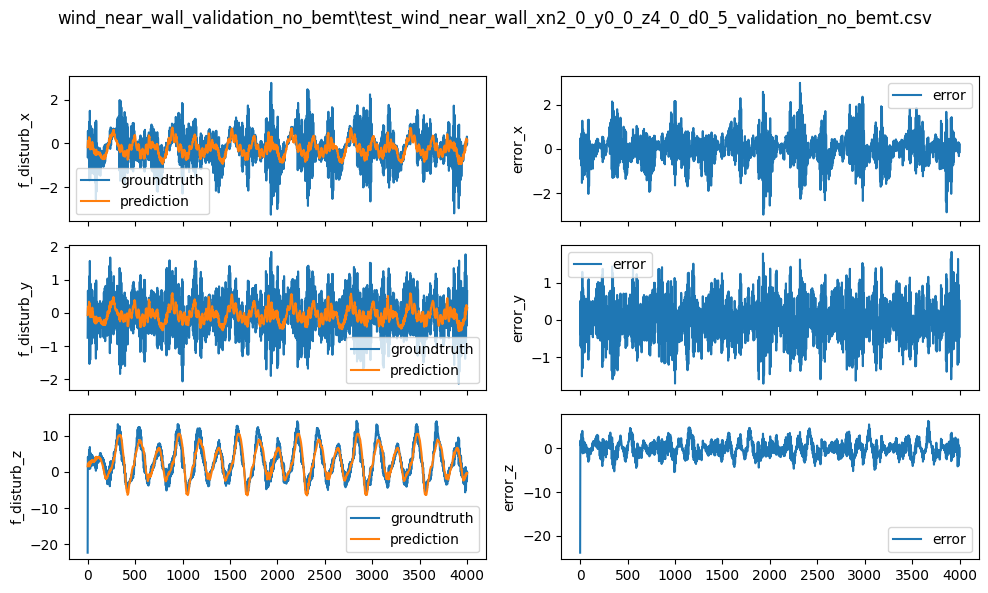

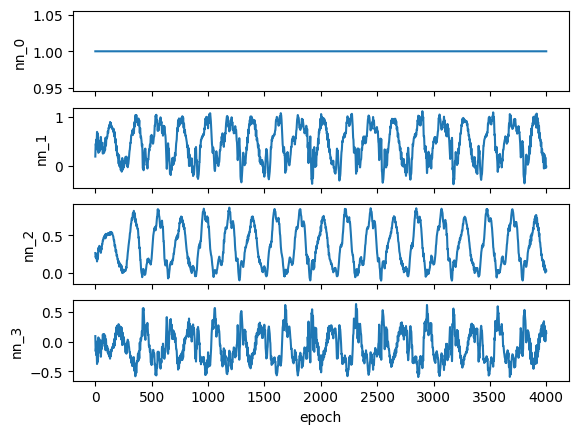

phi_out: tensor([[ 1.0000,  0.1964,  0.2640,  0.0917],
        [ 1.0000,  0.2887,  0.2409,  0.0025],
        [ 1.0000,  0.4207,  0.2147, -0.1272],
        ...,
        [ 1.0000, -0.0098,  0.1173,  0.2175],
        [ 1.0000,  0.0349,  0.1001,  0.1609],
        [ 1.0000,  0.1127,  0.0727,  0.0707]])
a = tensor([[ 0.0059,  0.2892,  3.3295],
        [-0.9541,  0.4823,  1.9523],
        [-0.7022, -1.9336,  0.6623],
        [-2.6695, -1.3108, -2.6488]])


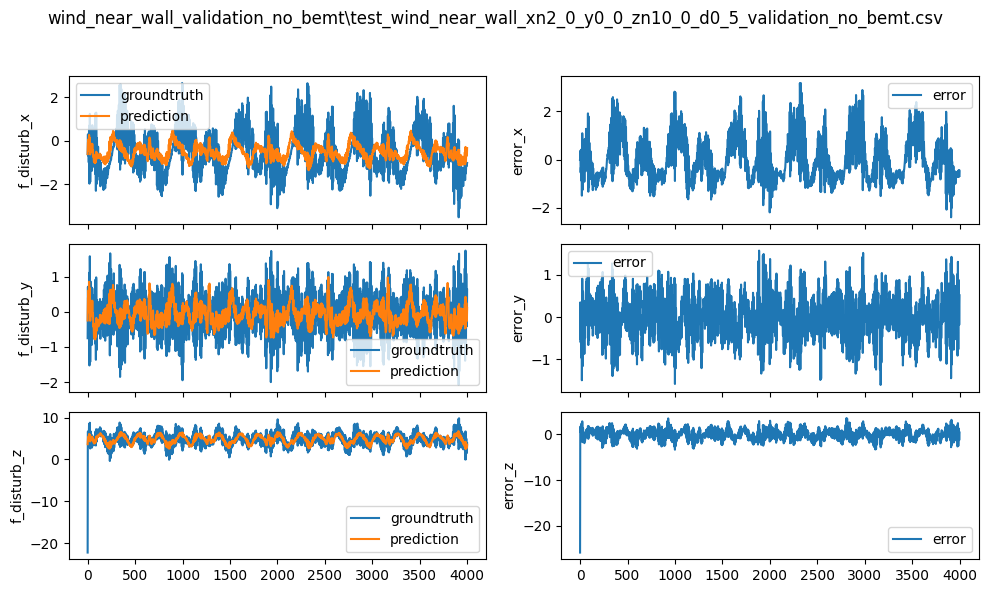

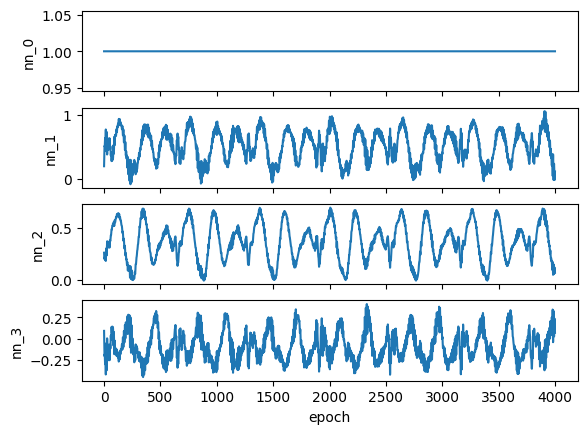

phi_out: tensor([[ 1.0000,  0.1995,  0.2605,  0.0901],
        [ 1.0000,  0.2636,  0.2329,  0.0239],
        [ 1.0000,  0.3802,  0.1976, -0.0966],
        ...,
        [ 1.0000, -0.0745,  0.0725,  0.2016],
        [ 1.0000, -0.0480,  0.0578,  0.1680],
        [ 1.0000, -0.0145,  0.0416,  0.1285]])
a = tensor([[  0.4925,   0.3647,  -0.3878],
        [ -1.1224,  -0.2138,  -6.8005],
        [ -1.5722,  -1.5045,   7.4990],
        [ -3.1287,  -1.7241, -13.3516]])


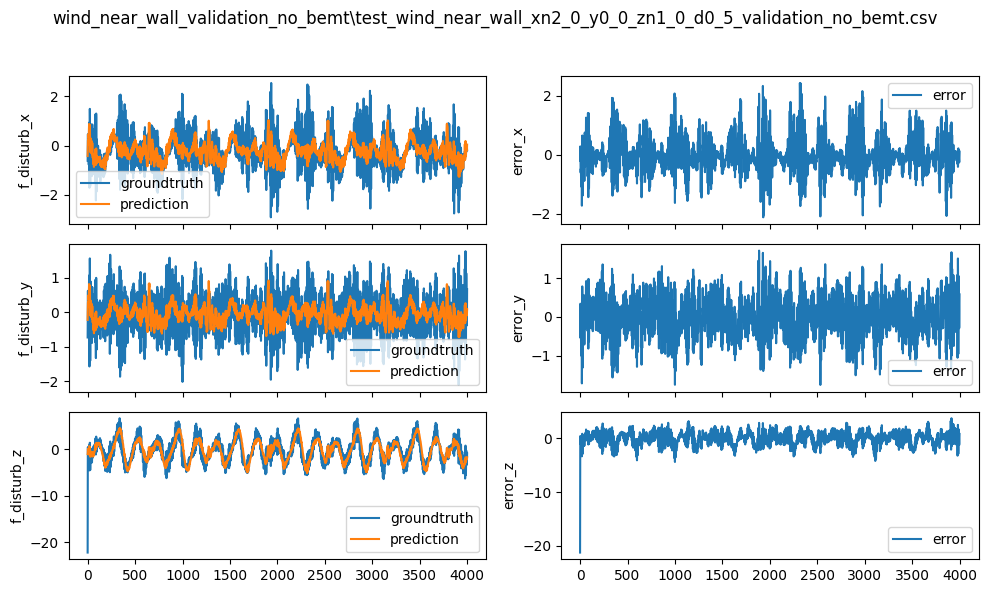

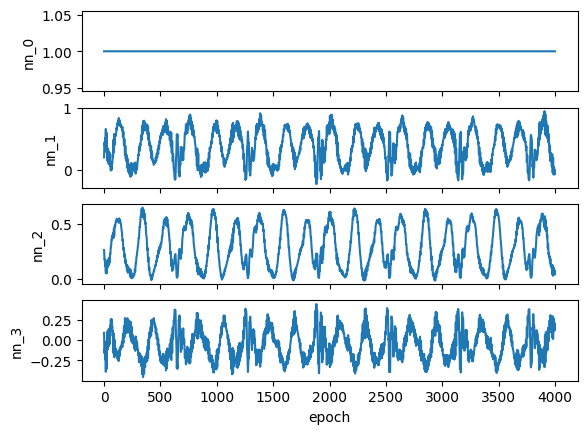

phi_out: tensor([[ 1.0000,  0.1970,  0.2613,  0.0925],
        [ 1.0000,  0.2695,  0.2316,  0.0184],
        [ 1.0000,  0.3921,  0.1958, -0.1080],
        ...,
        [ 1.0000, -0.0603,  0.0877,  0.1968],
        [ 1.0000, -0.0341,  0.0732,  0.1633],
        [ 1.0000,  0.0099,  0.0537,  0.1119]])
a = tensor([[ 0.4045,  0.3450, -0.2242],
        [-1.0064,  0.0951, -2.6325],
        [-1.7986, -1.8706,  2.7675],
        [-3.2521, -1.6273, -8.2577]])


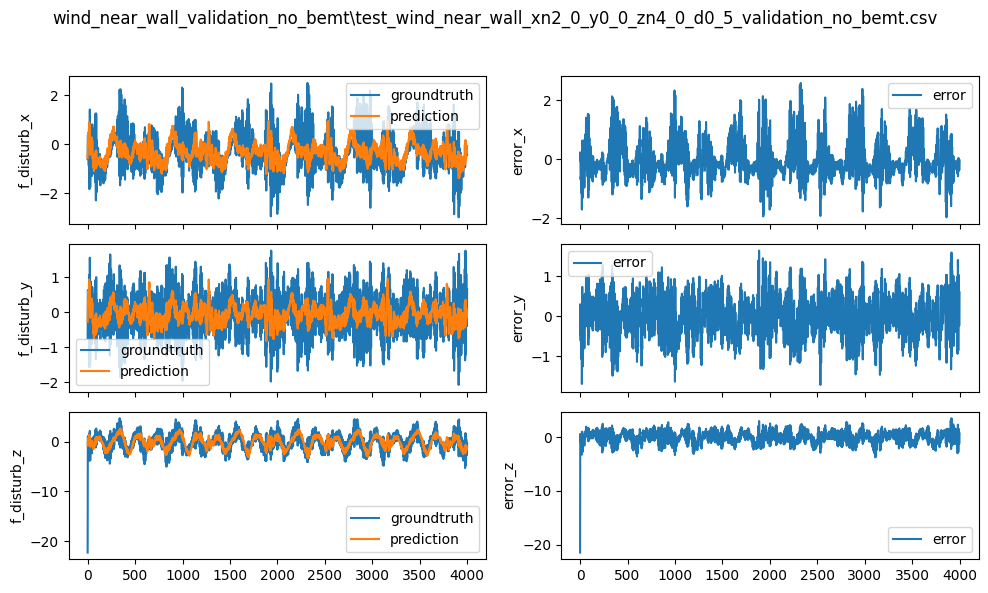

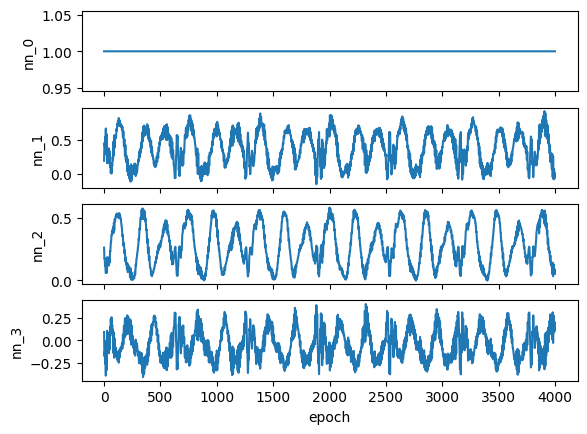

phi_out: tensor([[ 1.0000,  0.1950,  0.2635,  0.0933],
        [ 1.0000,  0.3028,  0.2277, -0.0128],
        [ 1.0000,  0.4489,  0.1894, -0.1583],
        ...,
        [ 1.0000, -0.0105,  0.1994,  0.3027],
        [ 1.0000,  0.0074,  0.1876,  0.2746],
        [ 1.0000,  0.0481,  0.1688,  0.2244]])
a = tensor([[-0.0257,  0.2586,  0.8807],
        [-2.2095, -0.5191,  0.3372],
        [-0.2105, -0.3117, 10.4860],
        [-2.8594, -0.7041, -5.4028]])


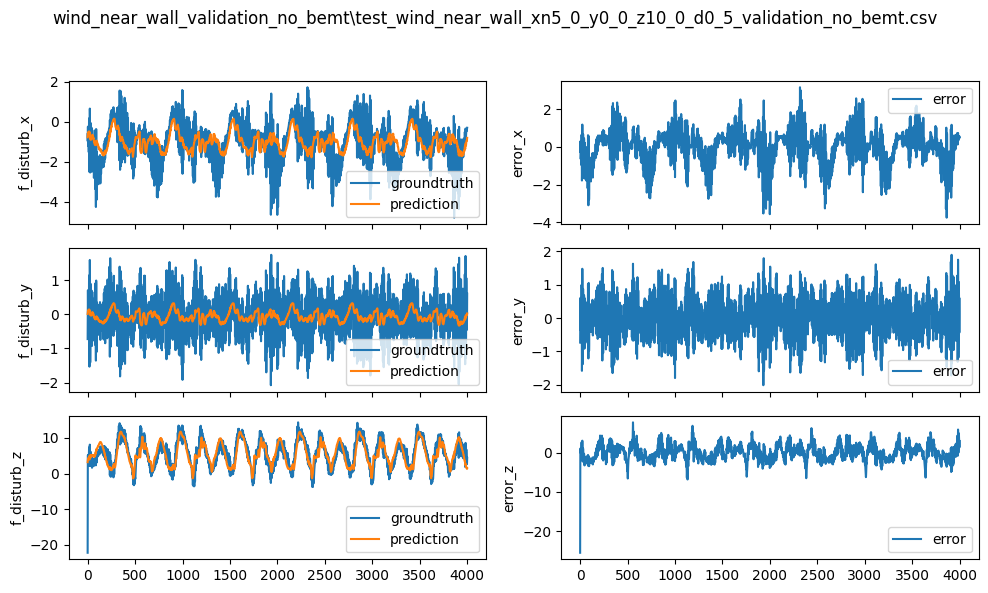

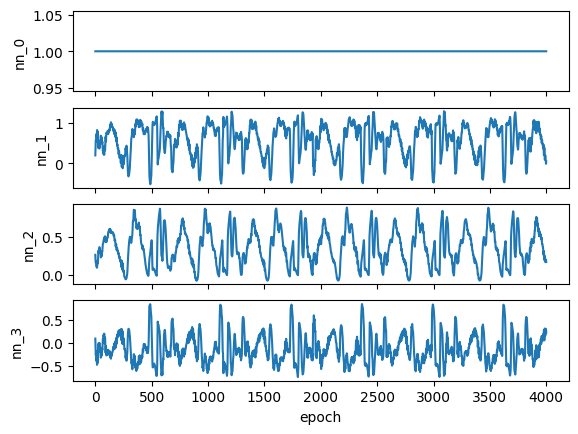

phi_out: tensor([[ 1.0000,  0.1931,  0.2629,  0.0962],
        [ 1.0000,  0.2816,  0.2287,  0.0069],
        [ 1.0000,  0.4215,  0.1877, -0.1358],
        ...,
        [ 1.0000, -0.0426,  0.0762,  0.1903],
        [ 1.0000, -0.0178,  0.0622,  0.1578],
        [ 1.0000,  0.0147,  0.0456,  0.1178]])
a = tensor([[  0.3386,   0.3330,   0.1914],
        [ -1.5594,  -0.2479,  -6.4469],
        [ -2.0018,  -1.3574,   9.0020],
        [ -3.7305,  -1.6675, -12.6536]])


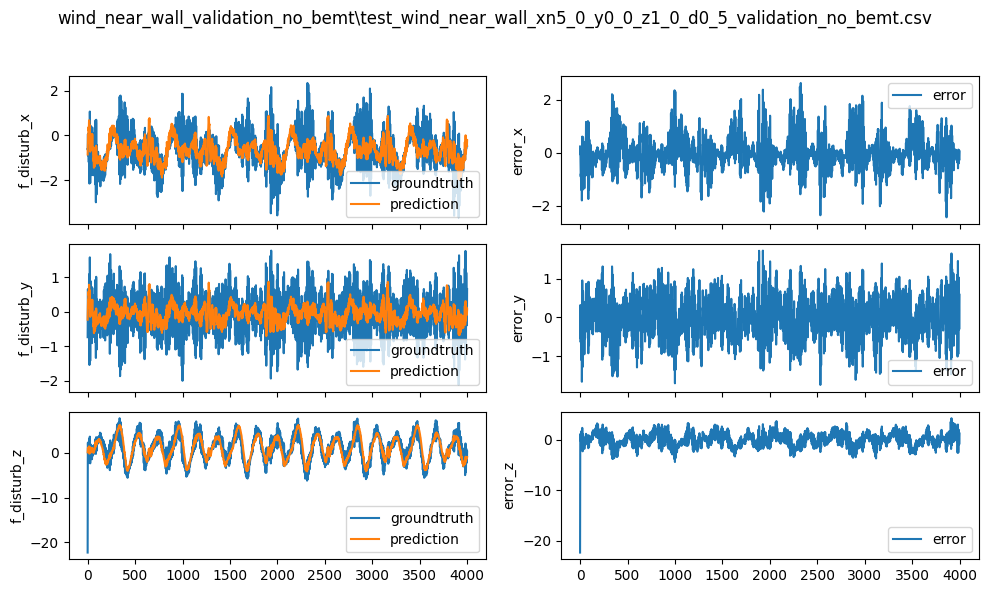

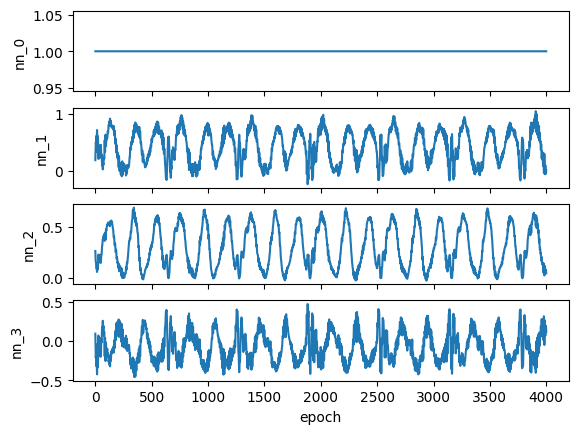

phi_out: tensor([[ 1.0000,  0.1990,  0.2615,  0.0897],
        [ 1.0000,  0.2966,  0.2267, -0.0075],
        [ 1.0000,  0.4358,  0.1878, -0.1473],
        ...,
        [ 1.0000,  0.0189,  0.0702,  0.1539],
        [ 1.0000,  0.0396,  0.0594,  0.1253],
        [ 1.0000,  0.0746,  0.0449,  0.0835]])
a = tensor([[  0.1015,   0.2996,   2.4980],
        [ -1.2561,  -0.4379, -10.4651],
        [ -1.3959,  -0.8791,  11.6508],
        [ -2.6840,  -1.4911, -17.4561]])


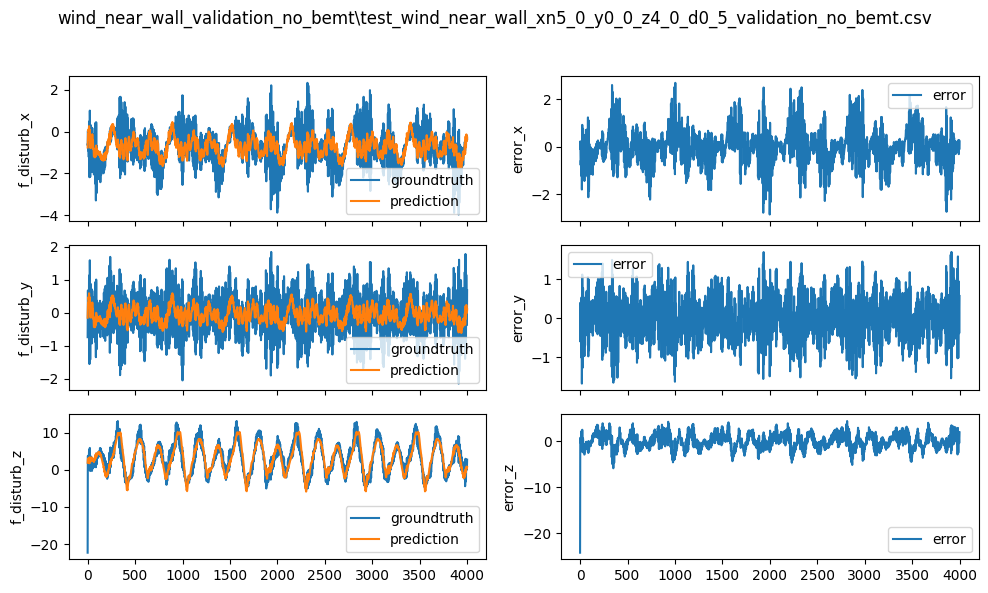

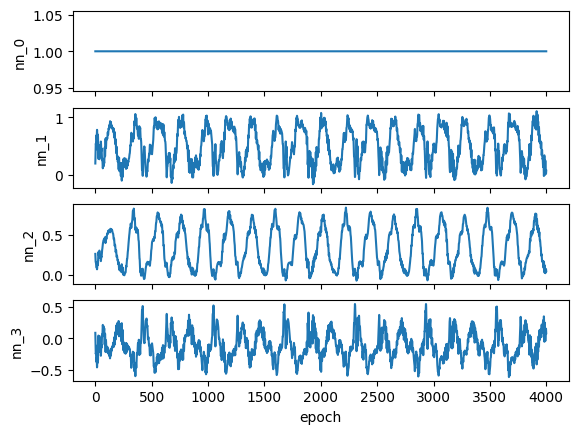

phi_out: tensor([[ 1.0000,  0.1933,  0.2646,  0.0945],
        [ 1.0000,  0.3190,  0.2244, -0.0282],
        [ 1.0000,  0.4799,  0.1827, -0.1871],
        ...,
        [ 1.0000,  0.0207,  0.1005,  0.1778],
        [ 1.0000,  0.0704,  0.0837,  0.1157],
        [ 1.0000,  0.1405,  0.0590,  0.0334]])
a = tensor([[-0.7309,  0.2418,  2.8672],
        [-1.2032,  0.4683,  2.1402],
        [-0.3877, -1.9499,  1.8532],
        [-2.2986, -1.3474, -1.9212]])


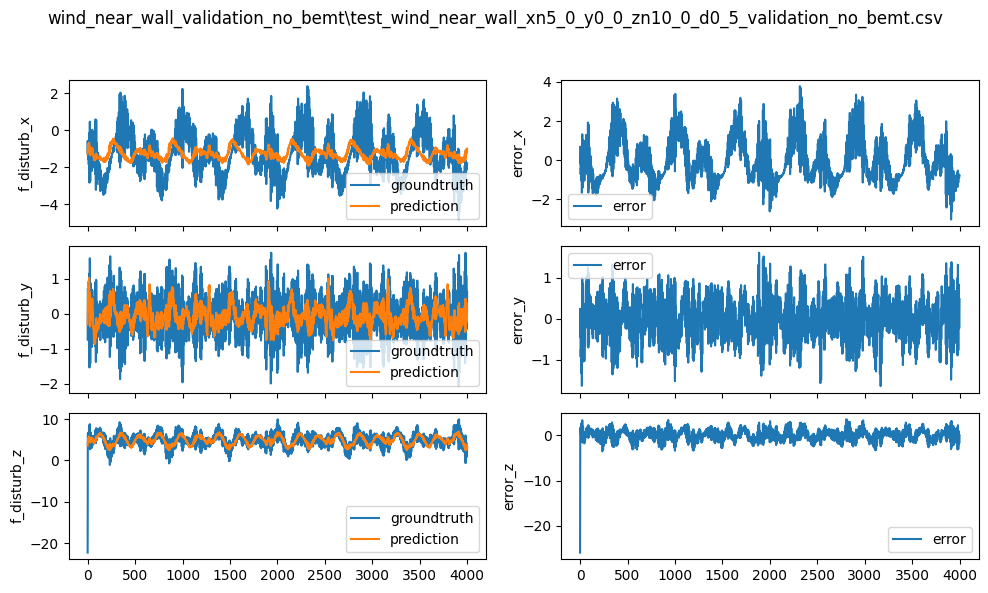

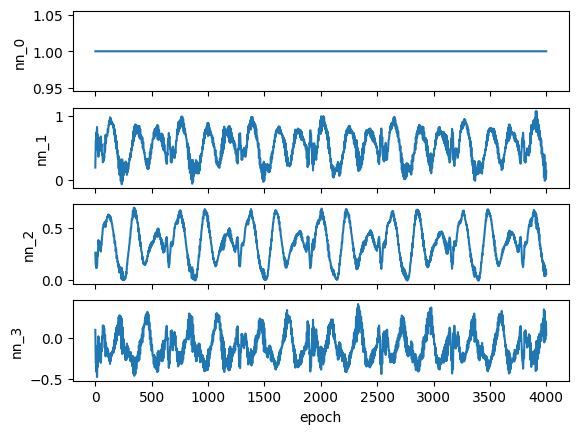

phi_out: tensor([[ 1.0000,  0.1976,  0.2609,  0.0918],
        [ 1.0000,  0.2755,  0.2268,  0.0124],
        [ 1.0000,  0.4118,  0.1838, -0.1277],
        ...,
        [ 1.0000, -0.0369,  0.0727,  0.1777],
        [ 1.0000, -0.0108,  0.0588,  0.1441],
        [ 1.0000,  0.0246,  0.0426,  0.1017]])
a = tensor([[  0.2177,   0.3044,  -0.3324],
        [ -1.4021,  -0.1179,  -5.6959],
        [ -1.9927,  -1.5061,   7.1644],
        [ -3.5662,  -1.6358, -12.0470]])


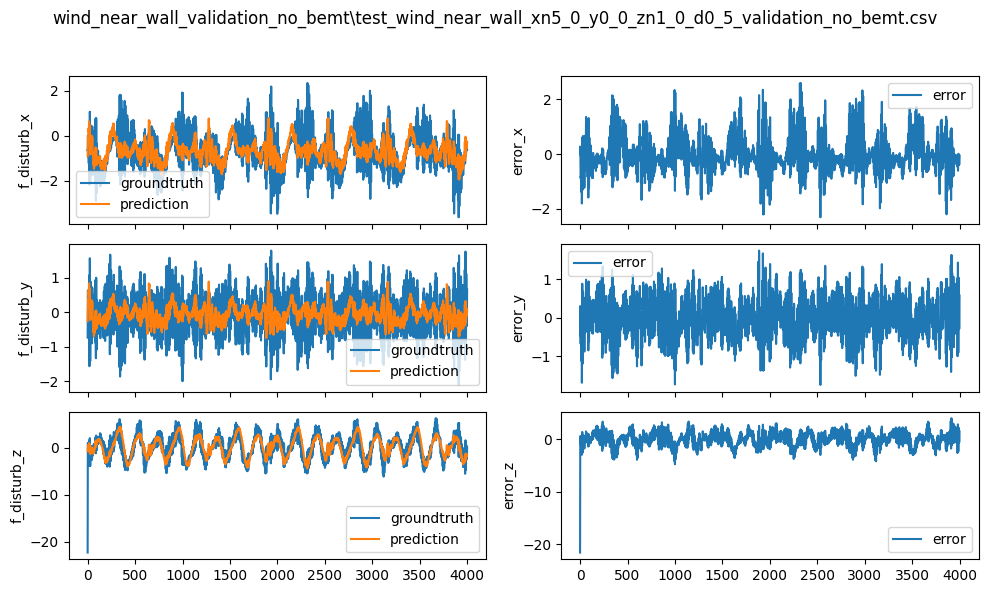

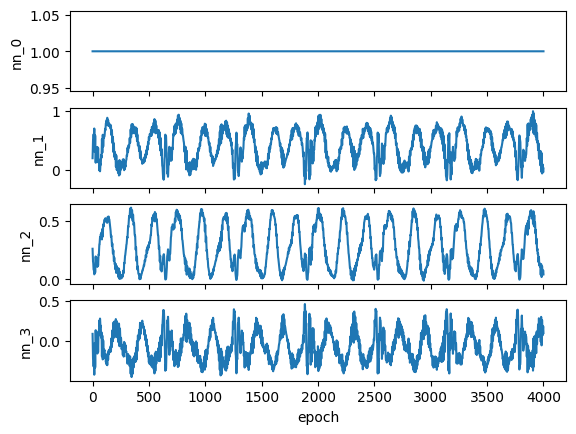

phi_out: tensor([[ 1.0000,  0.1980,  0.2609,  0.0911],
        [ 1.0000,  0.2892,  0.2205, -0.0015],
        [ 1.0000,  0.4331,  0.1732, -0.1490],
        ...,
        [ 1.0000, -0.0367,  0.0783,  0.1734],
        [ 1.0000, -0.0088,  0.0640,  0.1384],
        [ 1.0000,  0.0334,  0.0457,  0.0892]])
a = tensor([[-2.4438e-03,  3.1109e-01, -3.2147e-01],
        [-1.1927e+00,  1.1641e-01, -2.3899e+00],
        [-2.2041e+00, -1.9397e+00,  3.0001e+00],
        [-3.5679e+00, -1.6686e+00, -8.0805e+00]])


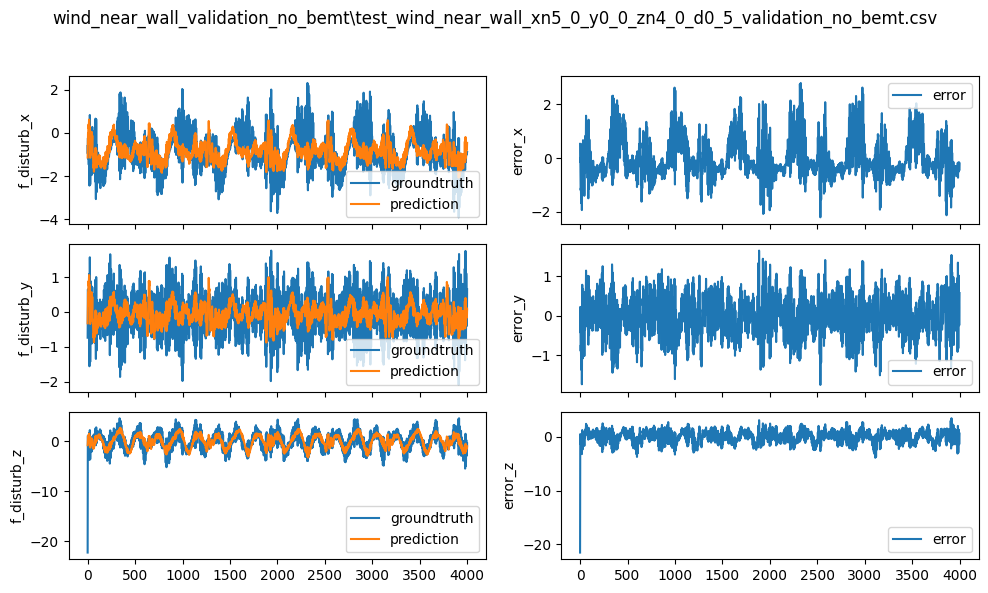

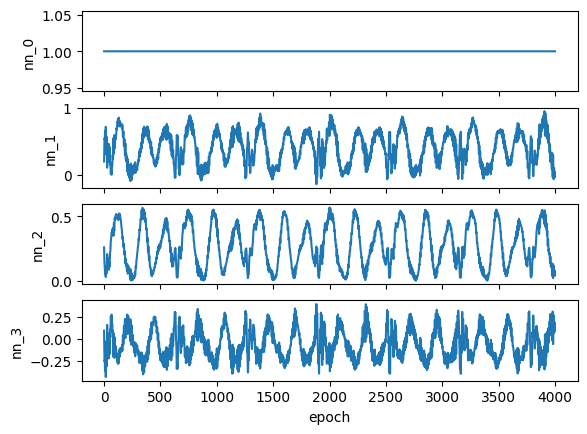

average rms for dim 0: 0.6901017730611043
average rms for dim 1: 0.5070633308240783
average rms for dim 2: 1.3941607725625085


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:71: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


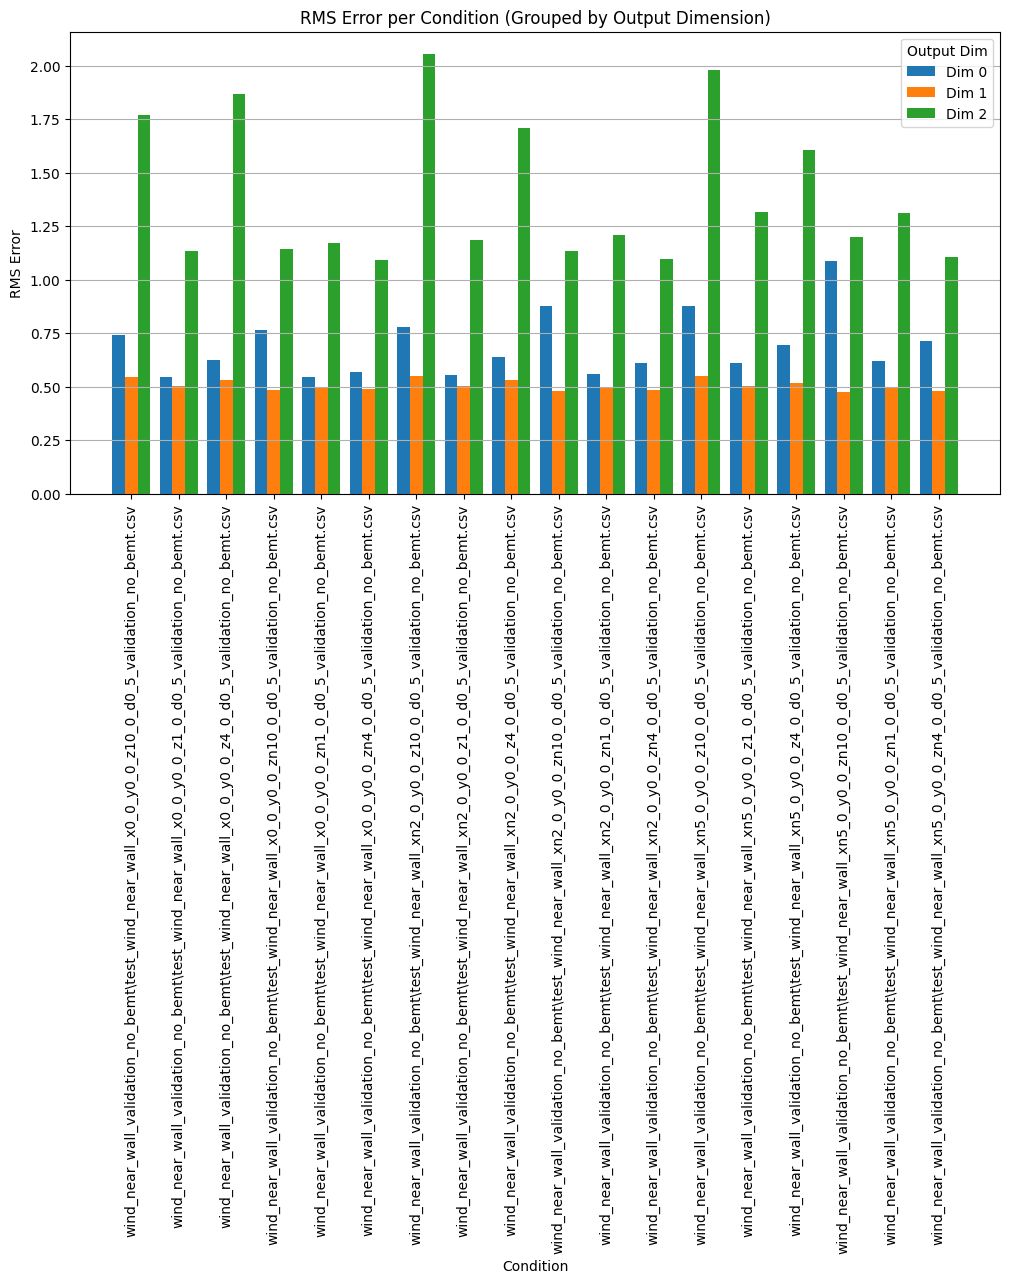

average mse for dim 0: 0.4963172539244611
average mse for dim 1: 0.25767779864120643
average mse for dim 2: 2.051017046769979


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:110: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


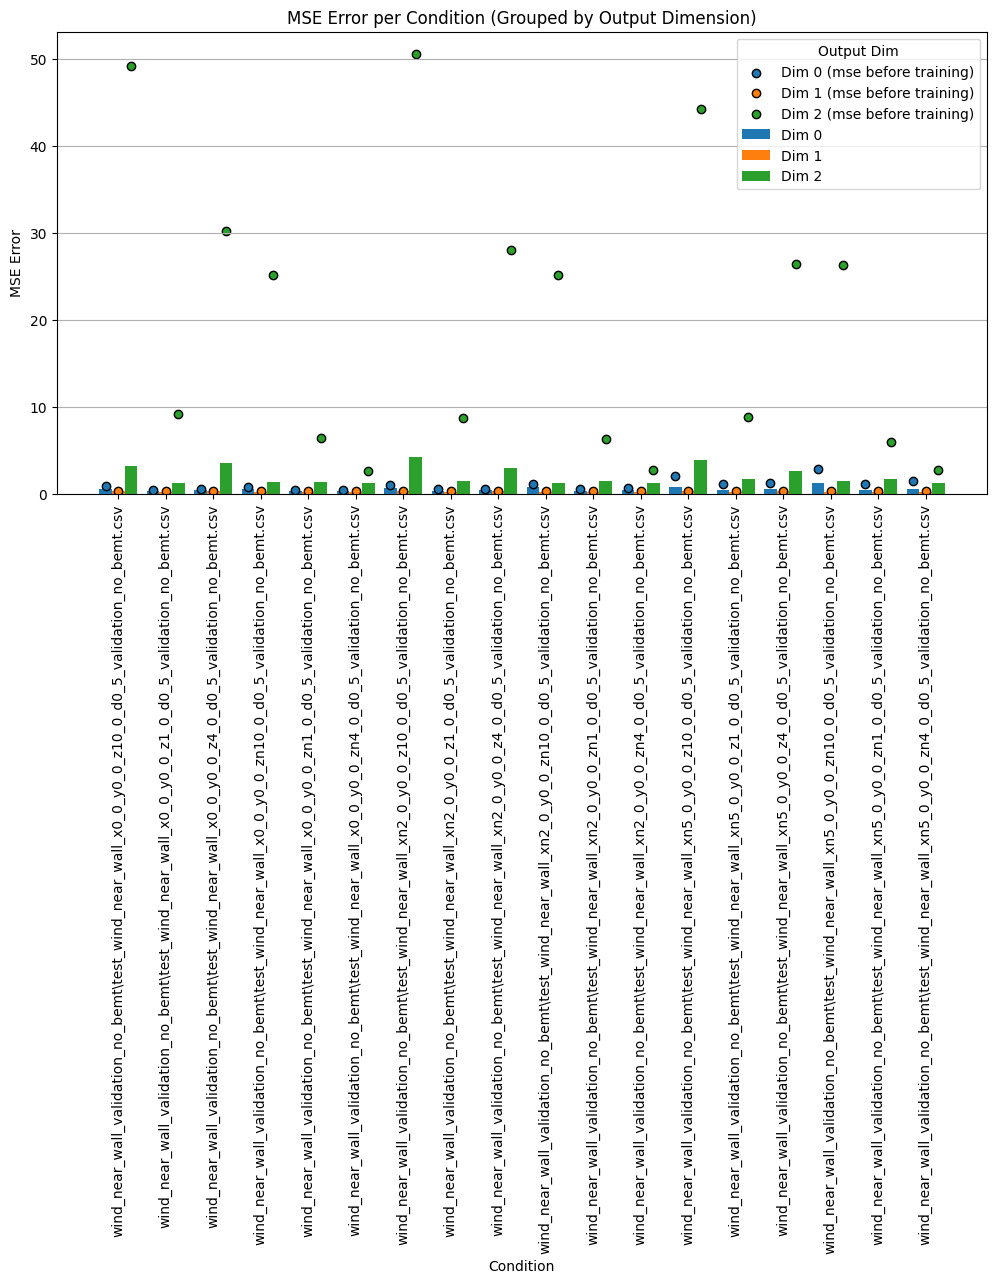

In [5]:
%matplotlib inline
model_name = training_subfolder

subfolder = validation_subfolder
subfolder = "wind_near_wall_validation_no_bemt"
# subfolder = "nf_validation_back2back"
data_list = generate_data_list(subfolder)
print("test Data List:")
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing

manager = factory.make_test_pipeline()

manager.set_up(
    data_menu=data_list,
    input_label_map_file=path1,
    model_name=model_name
)

# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.test()
plt.show()  
